In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import mallet as mal
from dariah_topics import evaluation

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

['corpus_txt/Kipling_TheEndofthePassage.txt',
 'corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Poe_TheMasqueoftheRedDeath.txt',
 'corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Doyle_AStudyinScarlet.txt']

In [3]:
path_csv = "corpus_csv"

doclist_csv = pre.create_document_list(path_csv, 'csv')
doclist_csv[:5]

['corpus_csv/Lovecraft_TheShunnedHouse.txt.csv',
 'corpus_csv/Kipling_TheJungleBook.txt.csv',
 'corpus_csv/Lovecraft_AttheMountainofMadness.txt.csv',
 'corpus_csv/Doyle_TheSignoftheFour.txt.csv',
 'corpus_csv/Howard_TheDevilinIron.txt.csv']

In [4]:
path_tei = "corpus_tei"

doclist_tei = pre.create_document_list(path_tei, 'xml')
doclist_tei[:5]

['corpus_tei/Schnitzler_Amerika.xml',
 'corpus_tei/Schnitzler_DerAndere.xml',
 'corpus_tei/Schnitzler_GeschichteeinesGenies.xml',
 'corpus_tei/Schnitzler_DerWitwer.xml',
 'corpus_tei/Schnitzler_DieFremde.xml']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [5]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

['corpus_txt/Kipling_TheEndofthePassage.txt',
 'corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Poe_TheMasqueoftheRedDeath.txt',
 'corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Doyle_AStudyinScarlet.txt']

#### Corpus laden

In [6]:
corpus_txt = pre.read_from_txt(doclist_txt)

In [7]:
corpus_csv = pre.read_from_csv(doclist_csv)

In [8]:
corpus_tei = pre.read_from_tei(doclist_tei)

#### Tokenisieren

In [9]:
doc_tokens = pre.filter_POS_tags(corpus_csv)
list(doc_tokens)[0][:5]

8     posthumous
11       immense
19         weird
20    fiction--a
31           old
Name: Lemma, dtype: object

In [10]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]
doc_tokens[0][:5]

['title', 'at', 'the', 'end', 'of']

In [11]:
doc_tokens = [list(pre.tokenize(tei)) for tei in list(corpus_tei)]
doc_tokens[0][:5]

['arthur', 'schnitzler', 'amerika', 'das', 'schiff']

#### Create Dictionaries

In [12]:
id_types, doc_ids = pre.create_dictionaries(doc_labels, doc_tokens)

#### Sparse BOW Model

In [13]:
sparse_bow = pre.create_mm(doc_labels, doc_tokens, id_types, doc_ids)

In [14]:
sparse_bow[:5]

0
doc_id token_id   
1      1         1
       1032      1
       11        1
       12        1
       2062      1

#### Convert to Doc-Topic Matrix

In [ ]:
'''import pandas as pd

doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

cols = [doc2id[key] for key in set(sparse_bow.index.get_level_values("doc_id"))]
#idx = [type2id[key] for key in set(sparse_bow.index.get_level_values("token_id"))]

set(sparse_bow.index.get_level_values("token_id"))

#doctopic_matrix = pd.DataFrame(columns=cols, index=idx)'''

#### Remove Features

In [15]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "en.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [16]:
sparse_df_stopwords_removed = pre.remove_features(sparse_bow, id_types, stopword_list)

In [17]:
print(len(sparse_bow))
print(len(sparse_df_stopwords_removed))

2856
2814


##### Create Feature Remove Lists

In [18]:
stopword_list = pre.find_stopwords(sparse_bow, id_types, 100)
len(stopword_list)

100

In [19]:
hapax_list = pre.find_hapax(sparse_bow, id_types)
len(hapax_list)

1719

##### Remove Features

In [20]:
feature_list = set(stopword_list).union(hapax_list)
clean_term_frequency = pre.remove_features(sparse_bow, id_types, feature_list)

In [21]:
len(clean_term_frequency)

350

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [22]:
#num_docs = max(sparse_bow.index.get_level_values("doc_id"))
#num_types = max(sparse_bow.index.get_level_values("token_id"))
#sum_counts = sum(sparse_bow[0])

#header_string = str(num_docs) + " " + str(num_types) + " " + str(sum_counts) + "\n"

#with open("gb_plain.mm", 'w', encoding = "utf-8") as f:
#    pass

#with open("gb_plain.mm", 'a', encoding = "utf-8") as f:
#    f.write("%%MatrixMarket matrix coordinate real general\n")
#    f.write(header_string)
#    sparse_bow.to_csv( f, sep = ' ', header = None)

pre.save_bow_mm(sparse_bow)

#### Import Market Matrix

In [23]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [24]:
mm = MmCorpus("gb_plain.mm")

In [ ]:
#in case you're only loading the corpus - build dict first

#import pickle

#pickle.dump( id_types, open( "gb_plain.dictionary", "wb" ) )

In [ ]:
#id_types = pickle.load(open("gb_plain.dictionary", 'rb'))

In [ ]:
#mm = gensim.corpora.MmCorpus("gb_all.mm")

In [ ]:
#id_types = pickle.load(open("gb_all.dictionary", 'rb'))

In [25]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

In [26]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=10)

In [27]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['prater',
 'besonderer',
 'weilt',
 'versöhnt',
 'spaziergang',
 'kuß',
 'marmorplatte',
 'reichte',
 'blaue',
 'betrüben']

In [ ]:
#Anzeige der id des ersten keywords aus dem topic
'''n = 0
for key, value in type2id.items():
    if value == topicTerms[n]:
        print(key)'''

In [ ]:
#Gensim-Funktion -> Anzeige des word_id-probability-mappings eines topics n
'''n = 0
topicN = model.get_topic_terms(n)
topicN'''

In [28]:
#Topic probabilities
topics = model.show_topics(num_topics = 10)
topics[:2]

[(0,
  '0.032*prater + 0.029*besonderer + 0.019*weilt + 0.019*reichte + 0.019*versöhnt + 0.010*spaziergang + 0.010*kuß + 0.010*jedenfalls + 0.009*blaue + 0.007*gaumens'),
 (1,
  '0.038*prater + 0.031*besonderer + 0.021*weilt + 0.015*versöhnt + 0.012*spaziergang + 0.012*kuß + 0.011*marmorplatte + 0.011*reichte + 0.011*blaue + 0.011*betrüben')]

In [ ]:
from scipy.io import mmread
test = mmread("gb_plain.mm")
import pandas as pd
pd.DataFrame(test.data)

## Topic Modeling mit Mallet

##### Mallet Binary erzeugen

In [ ]:
'''import os

#Variablen zum Testen
path_to_mallet = "/home/sina/Uni/Dariah/mallet/bin/mallet"

path_to_corpus = os.path.join(os.path.abspath('.'), 'corpus_txt')
assert os.path.exists(path_to_corpus)

malletBinary = mal.create_mallet_binary(path_to_corpus, path_to_mallet)
malletBinary'''

##### Mallet output erzeugen

In [ ]:
'''outfolder = os.path.join(os.path.abspath('.'), "tutorial_supplementals/mallet_output")
mal.create_mallet_model(malletBinary,outfolder)'''

##### Matrix von Mallet output erzeugen

In [ ]:
'''basepath = os.path.join(os.path.abspath('.'), "tutorial_supplementals/mallet_output")
doc_topics = os.path.join(basepath, "doc_topics.txt")'''

In [ ]:
'''doctopicsMatrix = mal.create_MalletMatrix(doc_topics)'''

In [ ]:
'''import pandas as pd
pd.DataFrame(doctopicsMatrix)'''

## Visualisierung 

In [ ]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

##### Create a document-topic matrix (that is a pandas data frame actually)

In [29]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

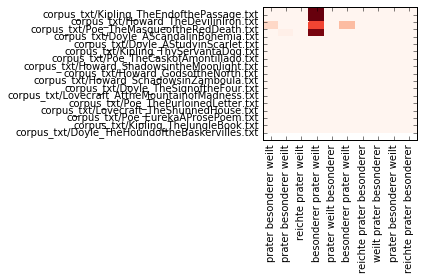

In [31]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

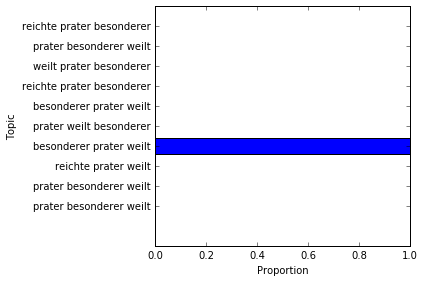

In [32]:
visual.plot_doc_topics(doc_topic, 0)

#### Heatmap

In [ ]:
#heatmap = visual.make_heatmap()

In [ ]:
#visual.save_heatmap("./visualizations/heatmap")

#### Interactive

In [ ]:
#vis = collection.Visualization(lda_model, corpus, dictionary, doc_labels, interactive=True)

In [ ]:
#vis.make_interactive()

In [ ]:
#vis.save_interactive("./visualizations/interactive")

## Evaluation

In [ ]:
segmented_topics = evaluation.topic_segmenter(model, type2id, 10)
segmented_topics[0][:5]

In [ ]:
umass_probability = evaluation.token_probability(doc_tokens, segmented_topics)
umass_probability

In [ ]:
umass = evaluation.calculate_umass(segmented_topics, umass_probability, doc_tokens, 10)
umass

In [ ]:
wiki_list = evaluation.wikipedia_table_crawler()

In [ ]:
wiki_corpus = evaluation.wikipedia_crawler(wiki_list, size=5)

In [ ]:
uci_probability = evaluation.token_probability(wiki_corpus, segmented_topics)

In [ ]:
pmi = evaluation.calculate_pointwise_mutual_information(segmented_topics, wiki_corpus, uci_probability)

In [ ]:
uci = evaluation.calculate_uci(pmi, wiki_corpus, 10)
uci

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)